In [1]:
import pandas as pd
import numpy as np
#surpress divide warnings
np.errstate(invalid='ignore', divide='ignore')
import matplotlib.pyplot as plt
import pickle
from src.data_tools.get_data import get_data

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.plotting_tools.draw_stack_plot_hists import draw_bckground, draw_signals, draw_data, draw_stackplot
from src.plotting_tools.SysHist import SysHist
from src.plotting_tools.Bins import Bins, bins
from src.plotting_tools.utils import ratio_plot_template
from src.data_tools.StackPlotter import get_stack_plotter
from src.plotting_tools.latexAssets import mll
from src.assets.output_dir import output_dir
output_dir

'/eos/cms/store/group/phys_exotica/bffZprime/assets_june_23'

In [5]:
split_bins = bins

In [6]:
from src.general.array_utils import moving_average, moving_sum, super_sample, super_sample_function, moving_avg_func, unp_array_to_nom_std
from src.plotting_tools.cms_format import cms_style, cms_format_fig

In [7]:
from scipy.optimize import curve_fit
from src.general.functions import power_func, power_law, make_bpoly, linear, parabola, make_bpoly_exp

/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scipy/1.7.1-c59502069094870046fda47cb5a5065e/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [8]:
from scipy.optimize import curve_fit
from src.general.functions import make_bpoly, lognorm, log_norm_np, log_norm_unp
from src.plotting_tools.SysHist import SysHist
import uncertainties
import uncertainties.unumpy as unp

In [9]:
cms_style()

In [10]:
outdir = '{}/abcd_test'.format(output_dir)
era = '2016'
ismc=0
isdata = ismc==0

#select the median version 
ismedian = False
if ismedian: postfix="_median"
else: postfix=""

In [11]:
sp = get_stack_plotter(output_dir, era, bins='none')

In [50]:
def compare_hists(fhist, dhist, ismc_pull = False, n=10, ndof=0, log=1, color='red', flabel="", dlabel="", 
                  dhist_isdata=0, fhist_is_data=0, ratio=False,  isabcd=0, **kwargs):
    fig, ax, rax = ratio_plot_template(figsize=(10,10))
    
    if isabcd:
        fhist.draw(ax, label=flabel, zorder=3,color=color)
    else:
        fhist.draw(ax, label=flabel, zorder=3)
    if dhist_isdata:
        ax.errorbar(dhist.calc_bin_centers(), dhist.nominal, yerr=dhist.std, color='black', label=dlabel,
           ls='', marker='o', zorder=3)
    else:
        dhist.draw(ax, label=dlabel, zorder=1, color=color, errorbar=False, draw_sys=0)#, sys_label='Background Systematics')
    
    x = fhist.calc_bin_centers()
    if isdata:
        cms_format_fig(era, ax, "\emph{Preliminary}")
    else:
        cms_format_fig(era, ax, "\emph{Simulation}")
    if log:
        ax.set_yscale('Log')
    ax.set_ylabel('Counts per GeV')
    
    #calc pull
    nom1_avg = moving_sum(fhist.nominal, n = n)
    nom2_avg = moving_sum(dhist.nominal, n = n)
    var1_avg = moving_sum(fhist.std**2, n = n)
    var2_avg = moving_sum(dhist.std**2, n = n)
    x_avg = moving_average(x, n=n)
    if ismc_pull:
        pull = (nom1_avg-nom2_avg)/(var2_avg+var1_avg)**.5
    else:
        pull = (nom1_avg-nom2_avg)/nom1_avg**.5
    pullsquare = pull**2
        
    
    if ratio:
        rax.plot(x, np.full(len(x), .5) , color='black', linestyle=':')
        rax.plot(x, np.full(len(x), 0) , color='black')
        rax.plot(x, np.full(len(x), 1.5) , color='black', linestyle=':') 
        rax.set_ylim(0,2)
        if fhist_is_data:
            rax.set_ylabel('Obs./Data')
        else:
            if isabcd: rax.set_ylabel('ABCD/Data')
            else: rax.set_ylabel('Fit/MC')
        if isdata:
            fhist.calc_ratio(dhist.nominal).draw(rax, zorder=1, color=color)
        else:
            fhist.calc_ratio(dhist.nominal).draw(rax, zorder=1)
        if dhist_isdata:
            dhist.calc_ratio(dhist.nominal).draw(rax, color=color, zorder=0)
        else:
            dhist.calc_ratio(dhist.nominal).draw(rax, color=color, zorder=0, errorbar=False)
    else:
        rax.plot(x, np.full(len(x), 1) , color='black', linestyle=':')
        rax.plot(x, np.full(len(x), 0) , color='black')
        rax.plot(x, np.full(len(x), -1) , color='black', linestyle=':')
        rax.set_ylim(-5,5)
        rax.set_ylabel('Pull')
        rax.plot(x_avg, pull)
        
    rax.set_xlabel('{} [GeV]'.format(mll))
    return  {'chi2': (pullsquare).sum()/(fhist.calc_nBins()-ndof),
             'fig': fig,
             'ax': ax,
             'rax': rax}
    

In [51]:
def fit_hist(func, hist, n=10, comp_hist_n =10, do_super_sample=1, ismc=False,  do_unc=1, color='red', 
             flabel="", dlabel="", dhist_isdata=0, fhist_is_data=0, **kwargs):
    x = np.array(hist.calc_bin_centers())
    if not isdata:
        popt, pcov = curve_fit(func, x, hist.nominal, 
                       **kwargs,
                       sigma=hist.std, maxfev = int(1e6))  
    else:
        #std is not optimal for data: zero and low count bins will be subotimal error estimates
        popt, pcov = curve_fit(func, x, hist.nominal, 
               **kwargs, maxfev = int(1e6))  
    if do_unc:
        #create fit values with uncertainties
        popt_unc = uncertainties.correlated_values(popt, pcov)
        #make_fit_hist
        y = log_norm_unp(x, *popt_unc)
        y_nom, y_std = unp_array_to_nom_std(y)
    else: 
        y_nom = func(x, *popt)
        varper = ((hist.nominal-y_nom)**2/y_nom).mean()
        y_std = (varper*y_nom)**.5
        y_std = y_nom**.5
    fit_hist = SysHist(
            y_nom,
            x*0, x*0, 
            y_std,
            np.array(hist.bin_edges)
        ).normalize().calc_ratio(1/hist.calc_sum())
    
    #rebin
    fit_hist = fit_hist.rebin(split_bins.bin_edges)
    hist = hist.rebin(split_bins.bin_edges)

    compare_dict = compare_hists(fit_hist, hist, ismc=ismc, n=comp_hist_n, color = color, ndof=5, flabel=flabel, dlabel=dlabel, dhist_isdata=dhist_isdata)
    
    return {**compare_dict, 
            "popt" : np.array(popt),
            "pcov": np.array(pcov),
            "fit_hist": fit_hist
           }

In [52]:
bottom_value = 120
top_value=400
feature='DiLepMass'
sp.x_range = (bottom_value, top_value)

In [53]:
from scipy.ndimage import gaussian_filter

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_22696/4156263178.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5


CRA
CRA nan array([1.38506910e+04, 8.09285132e-01, 8.05977066e+01, 7.62996824e+01])


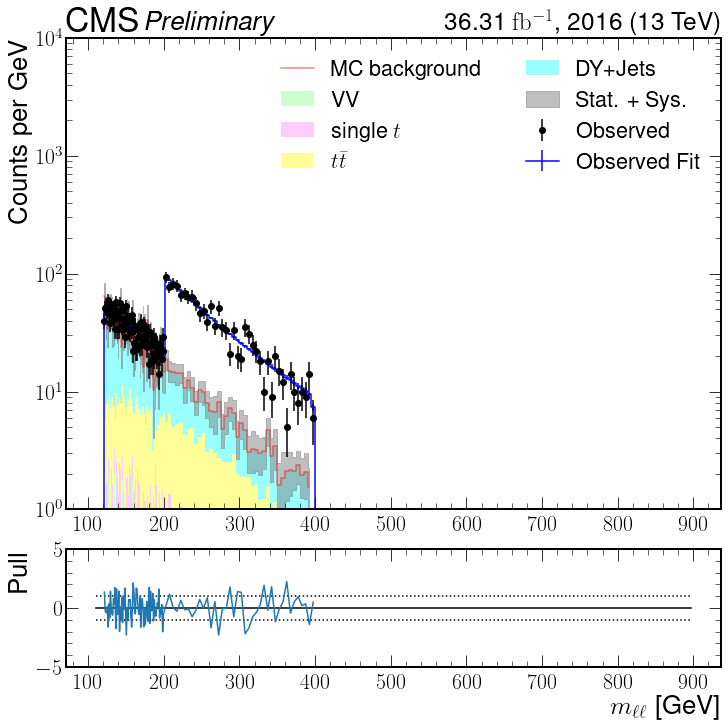

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


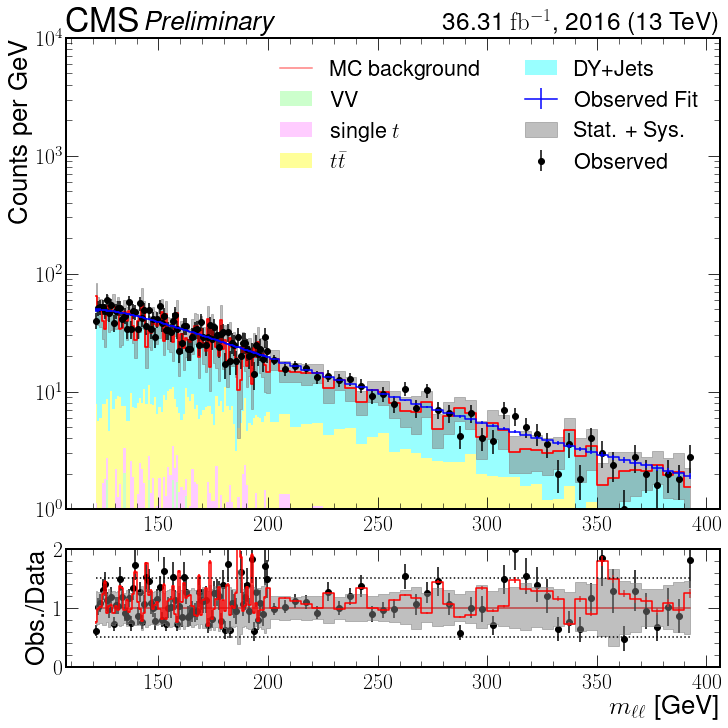

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_22696/4156263178.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5


CRB
CRB nan array([1.04016765e+04, 6.81786705e-01, 5.93528101e+01, 8.64463681e+01])


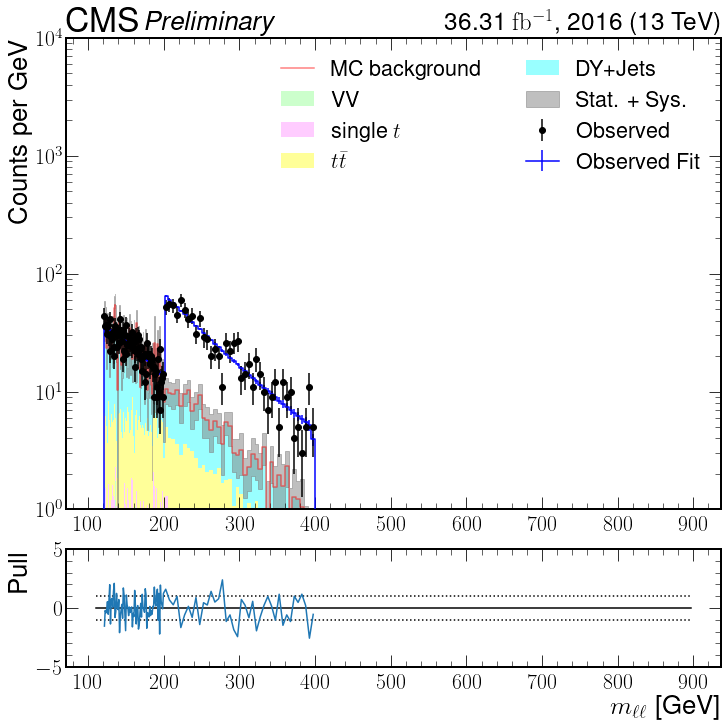

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


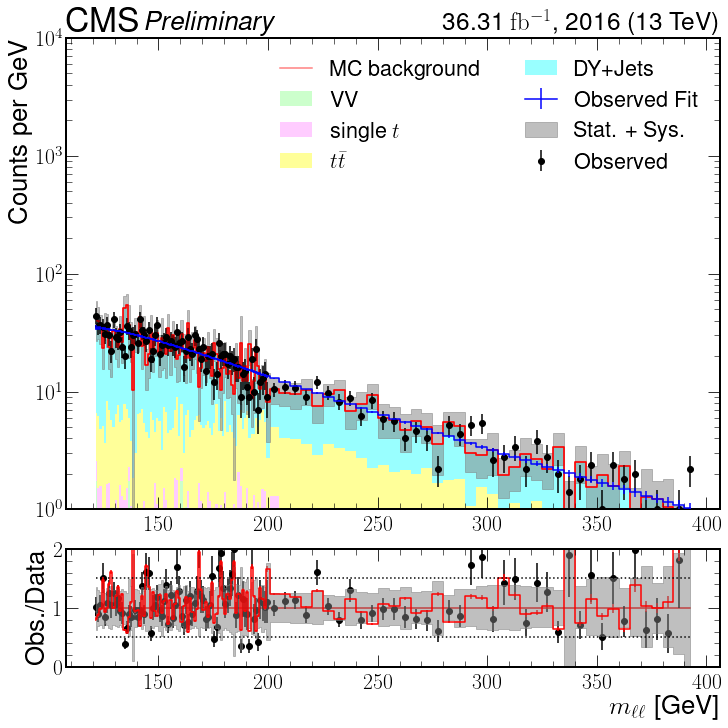

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_22696/4156263178.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5


CRC
CRC nan array([6.74005086e+04, 7.68465329e-01, 7.28508298e+01, 7.48831483e+01])


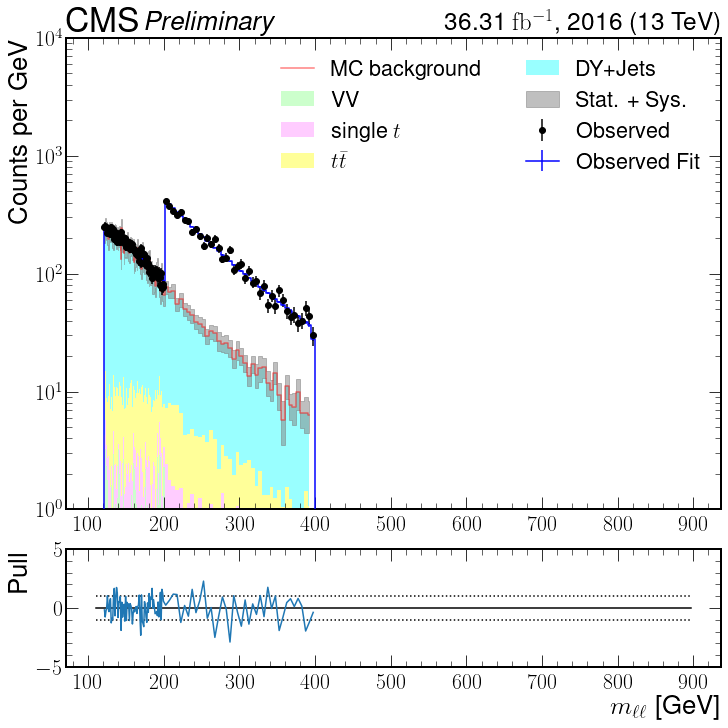

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


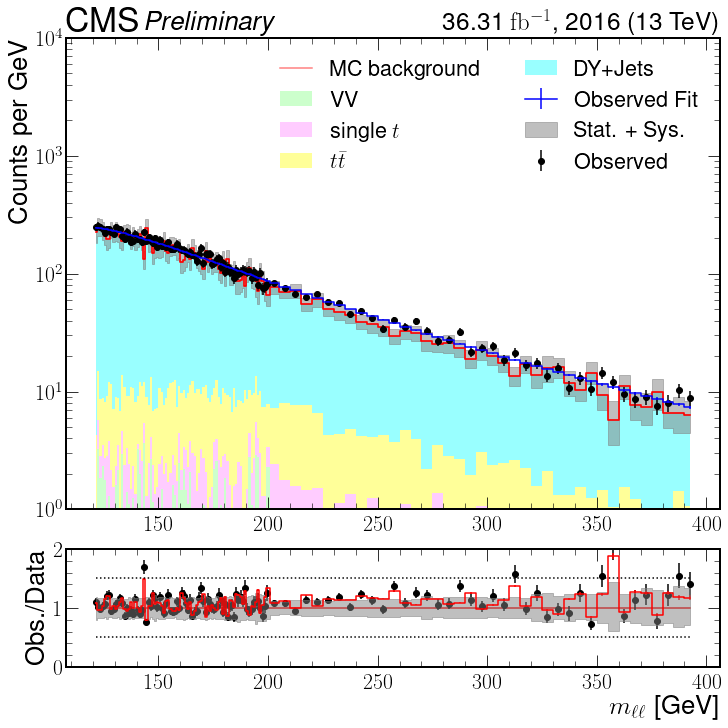

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_22696/4156263178.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5


CRD
CRD nan array([1.02788185e+05, 7.22566338e-01, 6.56257793e+01, 7.77998534e+01])


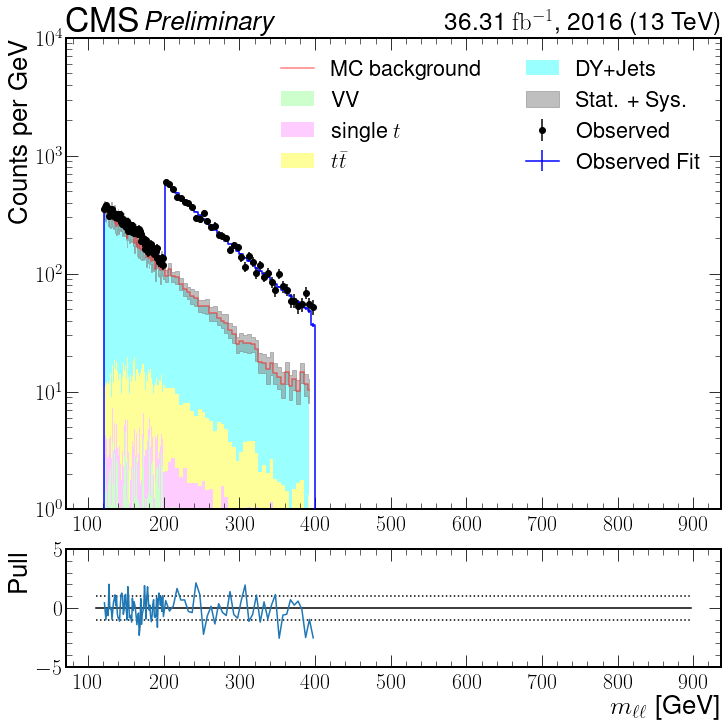

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


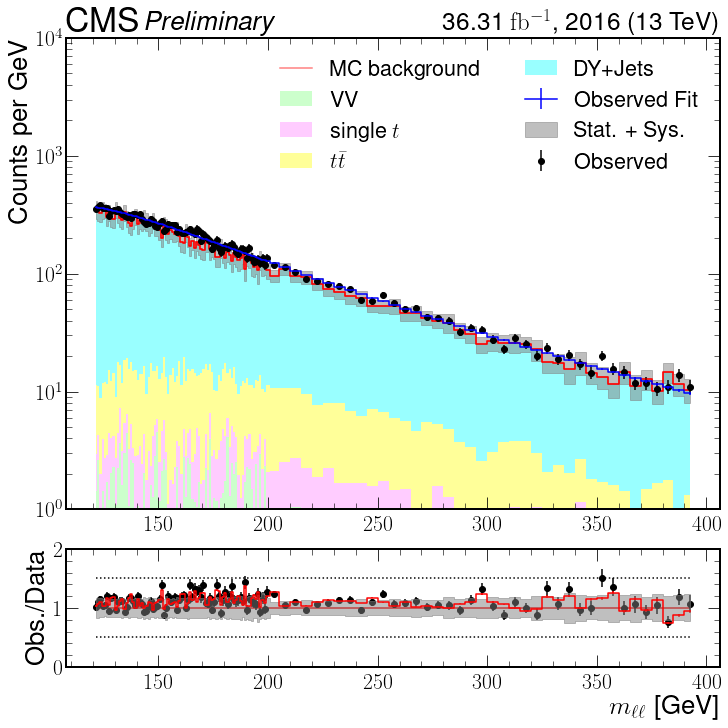

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_22696/4156263178.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5


CRA2
CRA2 nan array([9.04066798e+03, 6.99164888e-01, 5.19787216e+01, 9.82365242e+01])


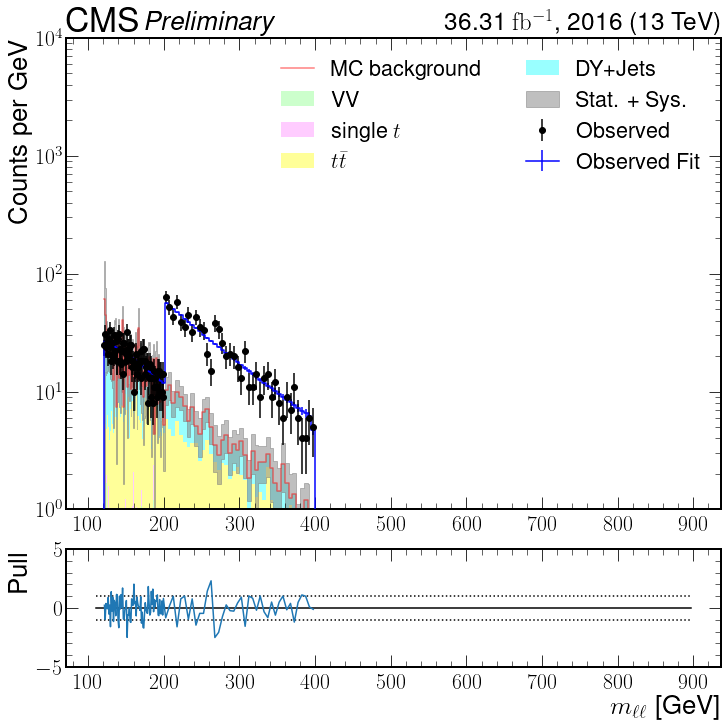

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


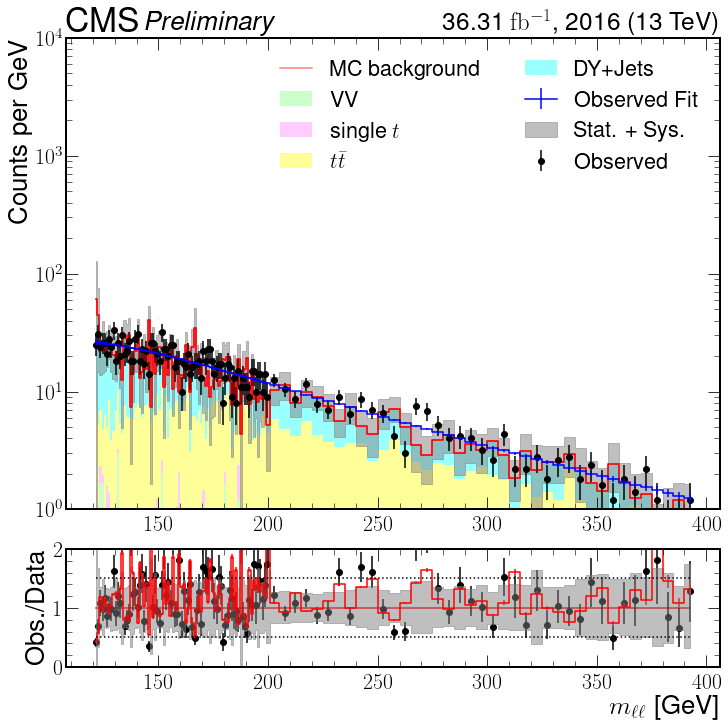

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_22696/4156263178.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


CRB2
CRB2 nan array([5.90052942e+03, 7.04692373e-01, 5.67903369e+01, 1.00000000e+02])


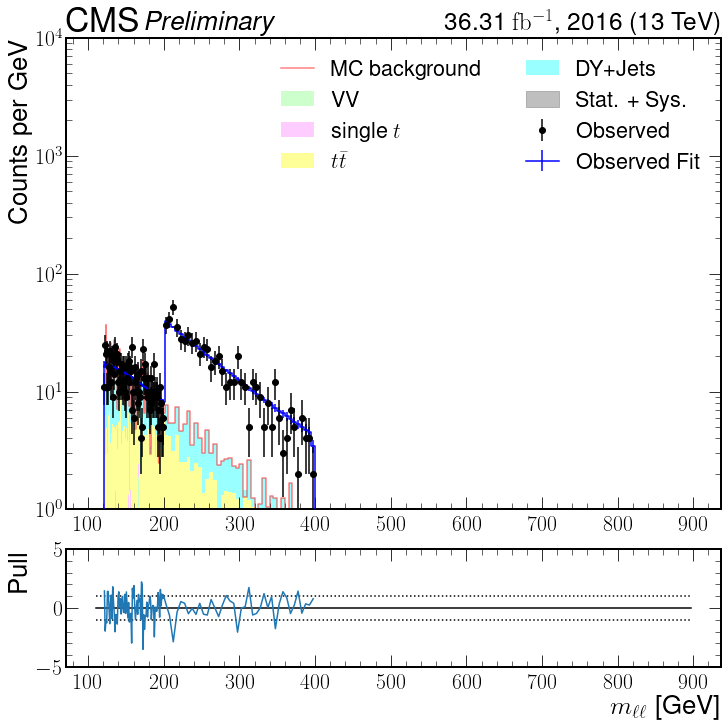

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


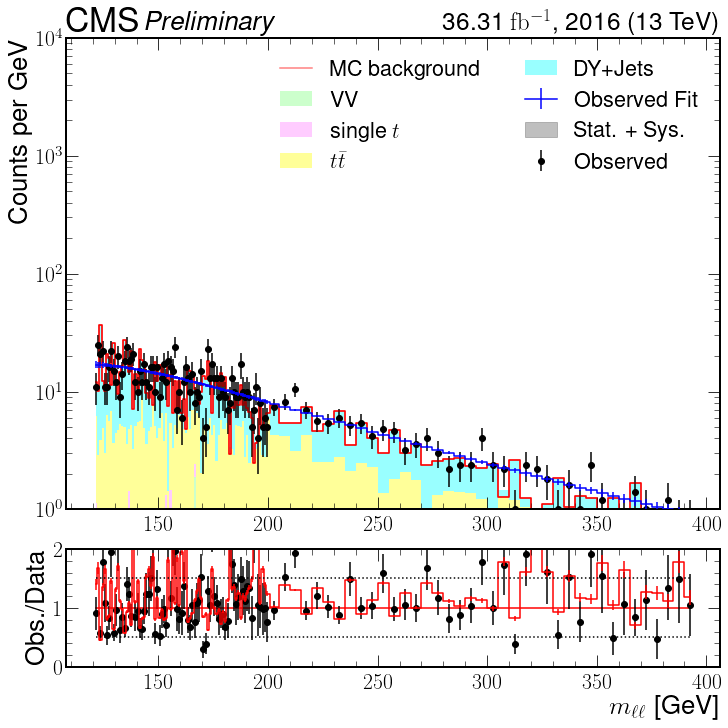

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_22696/4156263178.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5


CRC2
CRC2 nan array([2.21243263e+04, 8.48191544e-01, 5.00000000e+01, 7.12397362e+01])


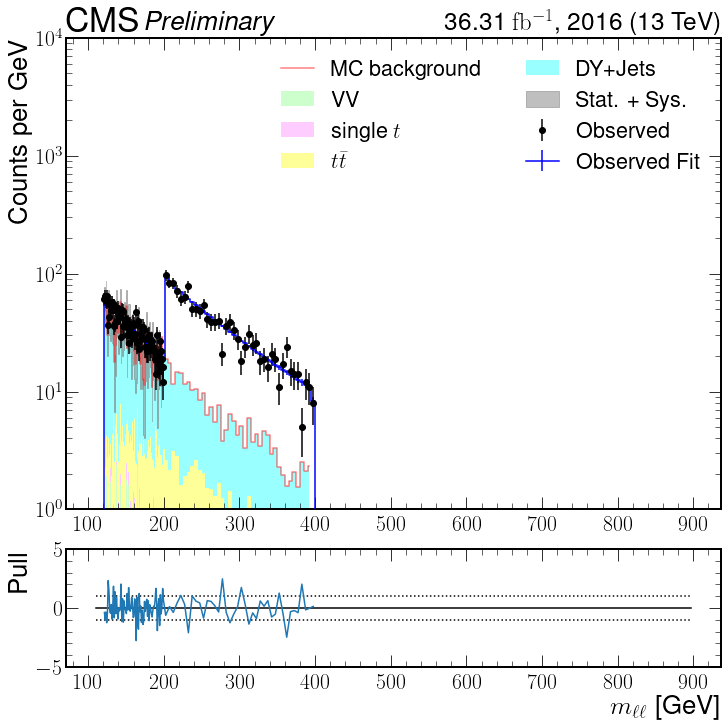

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


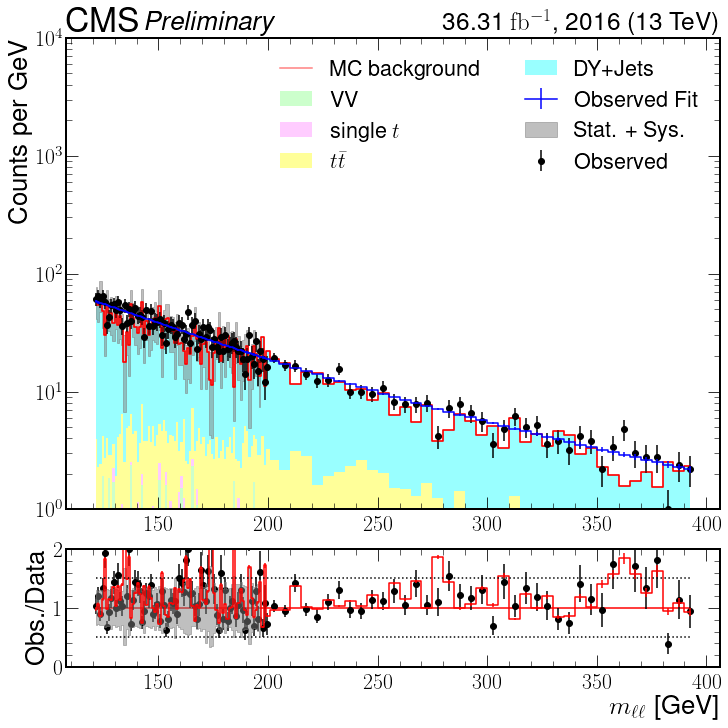

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_22696/4156263178.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


CRD2
CRD2 nan array([3.10129684e+04, 8.07572880e-01, 5.00000000e+01, 7.40127551e+01])


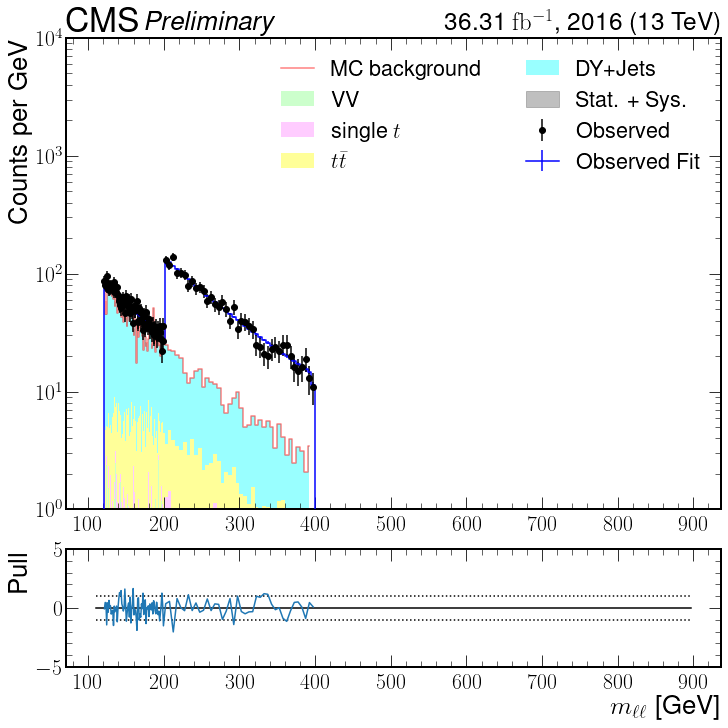

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


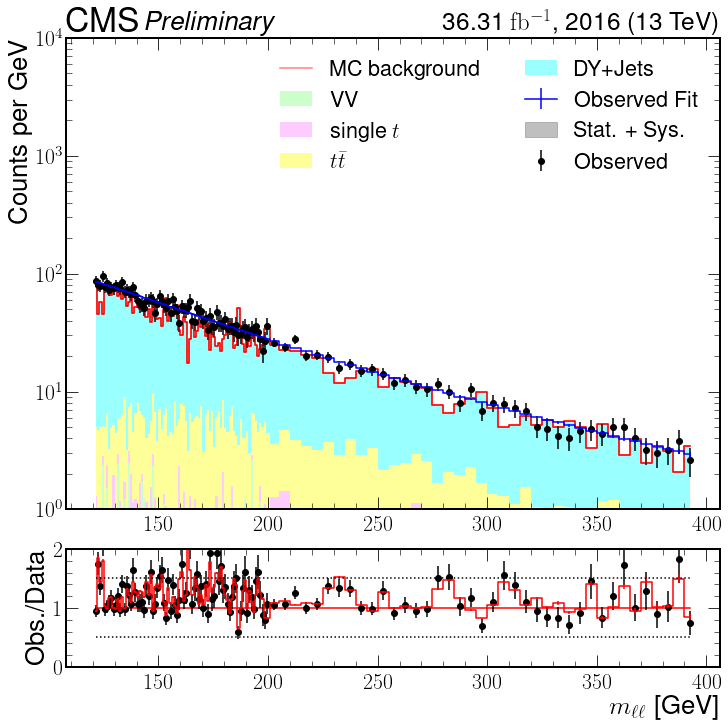

In [54]:
#test_regions = ["CRA_median", "CRB_median", "CRC_median", "CRD_median", "CRA2_median", "CRB2_median", "CRC2_median", "CRD2_median"]
test_regions = ["CRA", "CRB", "CRC", "CRD", "CRA2", "CRB2", "CRC2", "CRD2"]
test_regions = [t+postfix for t in test_regions]

comp_hist_n = 1
sp.rebin = 0
fit_dict = {}
for reg in test_regions:
    #data for fitting, data or MC?
    if isdata:
        _plot_dict = sp.make_data_hist(feature, reg)
    else:
        _plot_dict = sp.combine_back(feature, reg)
    #reduce the range for fitting
    hist = _plot_dict.reduce_range(bottom=bottom_value, top=top_value)
    if ismc: hist.std += gaussian_filter(hist.std,2)
    #hist.up *=0
    #hist.down *=0
    total_events = hist.nominal.sum()
    #fit the hist
    flabel='Observed Fit' if isdata else 'MC Fit'
    dlabel = 'Observed' if isdata else None
    # fit and pull plot
    
    
    curve_fit_chi2 = fit_hist(log_norm_np, hist, comp_hist_n=comp_hist_n, do_super_sample=0, 
                              ismc=ismc, p0=[total_events*10, .8, 80, 70], 
                              bounds = ([0, .2, 50, 50], [total_events*100, 1, 100, 100]),
                              do_unc=1, flabel=flabel, dlabel=dlabel, dhist_isdata=isdata,fhist_is_data=isdata,
                             )
    
    #background
    sp.rebin = split_bins.bin_edges
    sp.draw_background(curve_fit_chi2['ax'], feature, reg, sys_label='Stat. + Sys.', errorbar=False)
    print(reg)
    fit_dict[reg] = curve_fit_chi2
    print(reg, curve_fit_chi2['chi2'],  repr(curve_fit_chi2['popt']))
    # reorder legend
    handles, labels = curve_fit_chi2['ax'].get_legend_handles_labels()
    order = [0,1,2,3,4,5,7,6]
    if ismc: order = np.linspace(0,len(handles)-1, len(handles), dtype=int)
    curve_fit_chi2['ax'].legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                                ncol=2)
    curve_fit_chi2['ax'].set_ylim(bottom=1e0, top=1e4)
    curve_fit_chi2['fig'].savefig('{}/fit_data_pull_era{}_ismc{}_reg{}_bottom{}_lognorm.pdf'.format(outdir,era,ismc,reg,bottom_value))
    plt.show()
    #200gev pull
    curve_fit_chi2['ax'].set_xlim(left=bottom_value, right=200)
    curve_fit_chi2['rax'].set_xlim(left=bottom_value, right=200)
    curve_fit_chi2['fig'].savefig('{}/fit_data_pull_era{}_ismc{}_reg{}_bottom{}_lognorm_200GeVMax.pdf'.format(outdir,era,ismc,reg,bottom_value))

    ### ratio plot
    #rebin to split binning for these plots
    #sp.rebin = 0 #split_bins.bin_edges
    bhist = sp.combine_back(feature, reg).make_density_hist()
    bhist.nominal += 1e-10
    fit_hist_rebin = curve_fit_chi2['fit_hist'].reduce_range(bottom=bottom_value, top=top_value).make_density_hist()
    ratio_dict = compare_hists(fit_hist_rebin, bhist, n=comp_hist_n, 
                               color = 'red', ndof=5, flabel=flabel, ratio=True, dhist_isdata=0, fhist_is_data=isdata)
    ratio_dict['ax'].legend()
    sp.draw_background(ratio_dict['ax'], feature, reg, sys_label='Stat. + Sys.', errorbar=False)
    if isdata:
        data_plot = sp.make_data_hist(feature, reg).make_density_hist()
        ratio_dict['ax'].errorbar(data_plot.calc_bin_centers(), data_plot.nominal, yerr=data_plot.std, 
                    color='black', label='Observed', ls='', marker='o', zorder=2)
        
        ratio_dict['rax'].errorbar(data_plot.calc_bin_centers(), data_plot.nominal/bhist.nominal,
                                   yerr=data_plot.std/bhist.nominal, 
                    color='black', ls='', marker='o', zorder=.5)        
        
    handles, labels = ratio_dict['ax'].get_legend_handles_labels()
    order = [0,1,2,3,4,6,5,7]
    if ismc: order = np.linspace(0,len(handles)-1, len(handles), dtype=int)
    ratio_dict['ax'].legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                                ncol=2)

    ratio_dict['ax'].set_ylim(bottom=1e0, top=1e4)
    ratio_dict['fig'].savefig('{}/fit_mc_ratio_era{}_ismc{}_reg{}_bottom{}_lognorm.pdf'.format(outdir,era,ismc,reg,bottom_value))
    plt.show()
    #200gev pull
    ratio_dict['ax'].set_xlim(left=bottom_value, right=200)
    ratio_dict['rax'].set_xlim(left=bottom_value, right=200)
    ratio_dict['fig'].savefig('{}/fit_mc_ratio_era{}_ismc{}_reg{}_bottom{}_lognorm_200GeVMax.pdf'.format(outdir,era,ismc,reg,bottom_value))
    sp.rebin = 0

In [55]:
#### abcd

In [56]:
def make_fit_hist(template_hist, reg):
    tmp_xrange = sp.x_range
    sp.x_range = (-np.inf, np.inf)
    template_hist = sp.combine_back(feature, reg)
    x = np.array(template_hist.calc_bin_centers())
    popt, pcov = fit_dict[reg]['popt'], fit_dict[reg]['pcov']
    popt_unc = uncertainties.correlated_values(popt, pcov)
    y = log_norm_unp(x, *popt_unc)
    y_nom, y_std = unp_array_to_nom_std(y)
    fit_hist = SysHist(
            y_nom,
            x*0, x*0, 
            y_std,
            np.array(template_hist.bin_edges)
        )
    sp.x_range = tmp_xrange
    return fit_hist

In [57]:
def make_abcd(nJets):
    A = make_fit_hist(bhist, 'CRD{}{}'.format(nJets,postfix))
    B = make_fit_hist(bhist, 'CRB{}{}'.format(nJets,postfix))
    C = make_fit_hist(bhist, 'CRC{}{}'.format(nJets,postfix))
    abcd = A.uncertainty_std_dev()*B.uncertainty_std_dev()/C.uncertainty_std_dev()
    print( A.uncertainty_std_dev().sum(), B.uncertainty_std_dev().sum(), C.uncertainty_std_dev().sum(), abcd.sum())
    abcd_nom, abcd_std = unp_array_to_nom_std(abcd)
    return SysHist(abcd_nom, abcd_nom*0,abcd_nom*0,abcd_std, A.bin_edges)

#def make_abcd(nJets):
#    A = make_fit_hist(bhist, 'CRD{}'.format(nJets))
#    B = make_fit_hist(bhist, 'CRB{}'.format(nJets))
#    C = make_fit_hist(bhist, 'CRC{}'.format(nJets))
#    abcd = A.uncertainty_std_dev()*B.uncertainty_std_dev()/C.uncertainty_std_dev()
#    print( A.uncertainty_std_dev().sum(), B.uncertainty_std_dev().sum(), C.uncertainty_std_dev().sum(), abcd.sum())
#    abcd_nom, abcd_std = unp_array_to_nom_std(abcd)
#    return SysHist(abcd_nom, abcd_nom*0,abcd_nom*0,abcd_std, A.bin_edges)

In [58]:
def find_68_env(abcd, data, njets):
    
    delta = abs(abcd-data)/abcd
    fig, ax = plt.subplots()
    cms_format_fig(era, ax, "\emph{Preliminary}")
    values = ax.hist(delta, bins = np.linspace(0,.3,100))
    total = 0
    for density,bins in zip(values[0]/sum(values[0]), values[1]):
        total+=density
        if total > .68: 
            print(bins)
            break
    ax.plot([bins,bins],[0,max(values[0])], label='68\% Envelope')
    ax.legend()
    ax.set_xlabel('(ABCD-Data)/ABCD')
    ax.set_ylabel('Counts')
    fig.savefig('{}/CR{}_closure.pdf'.format(outdir,njets))
    return bins

In [59]:
def draw_outside_closure(ax, bin_centers, nom, nom2, std, closure_percent, color='red', **kwargs):
    outside_closure = abs(nom-nom2)/nom2>closure_percent
    bin_centers = np.array(bin_centers)
    ax.errorbar(bin_centers[outside_closure], nom[outside_closure], yerr=std[outside_closure], color=color, ls='', marker='o',  **kwargs) 


(3.389+/-0.006)e+04 3424+/-20 (2.322+/-0.006)e+04 5001+/-34
0.15151515151515152


/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


7945+/-25 1997+/-14 5455+/-25 2908+/-23
0.1787878787878788


/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


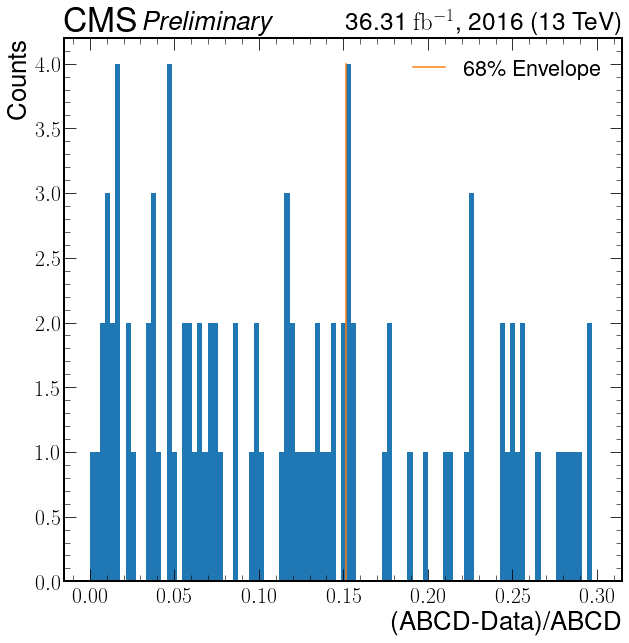

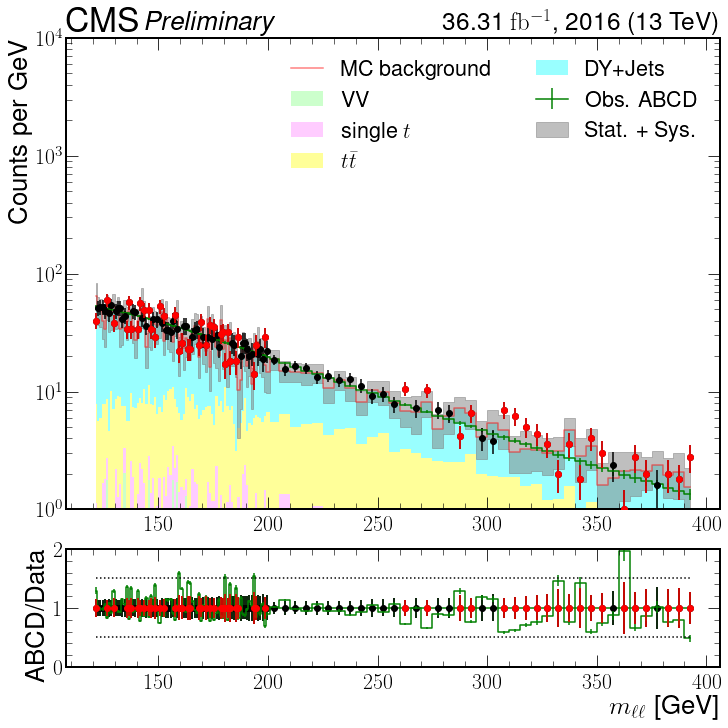

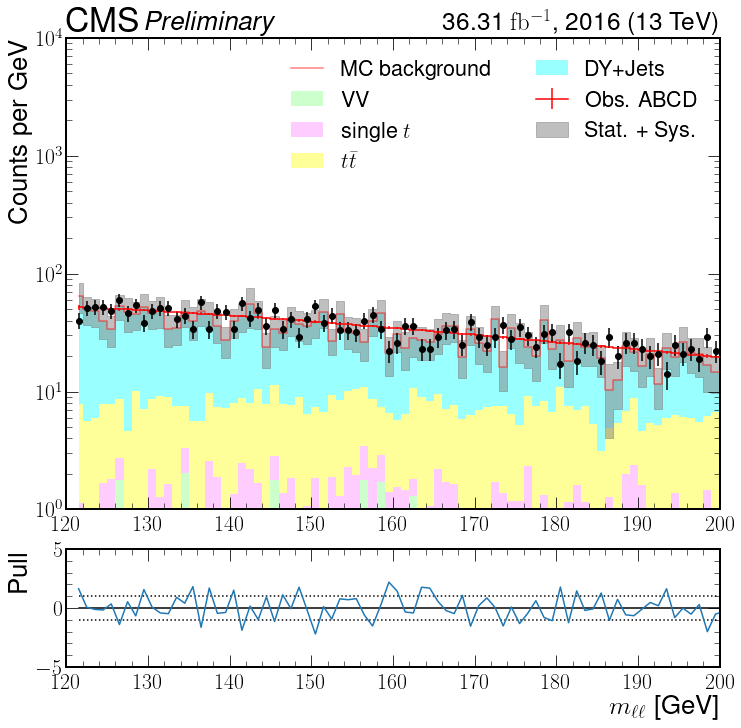

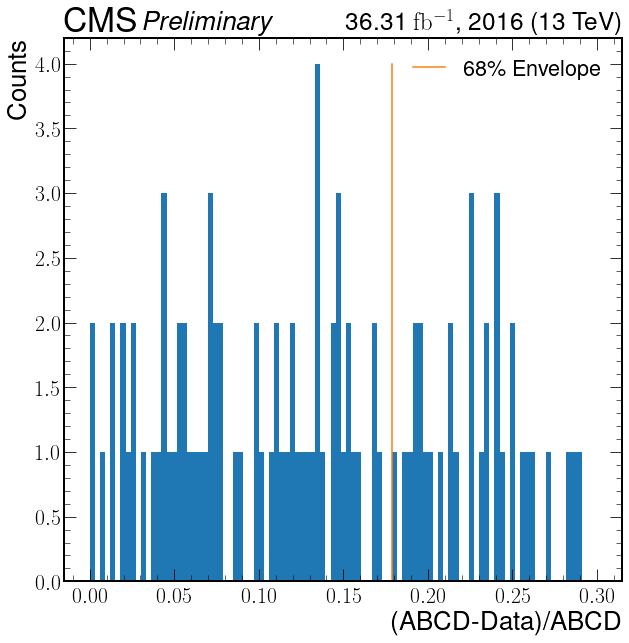

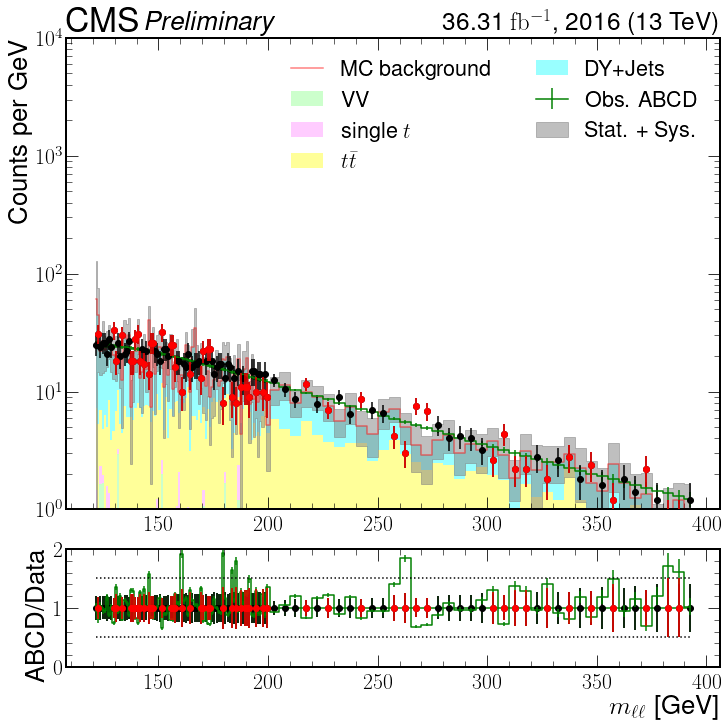

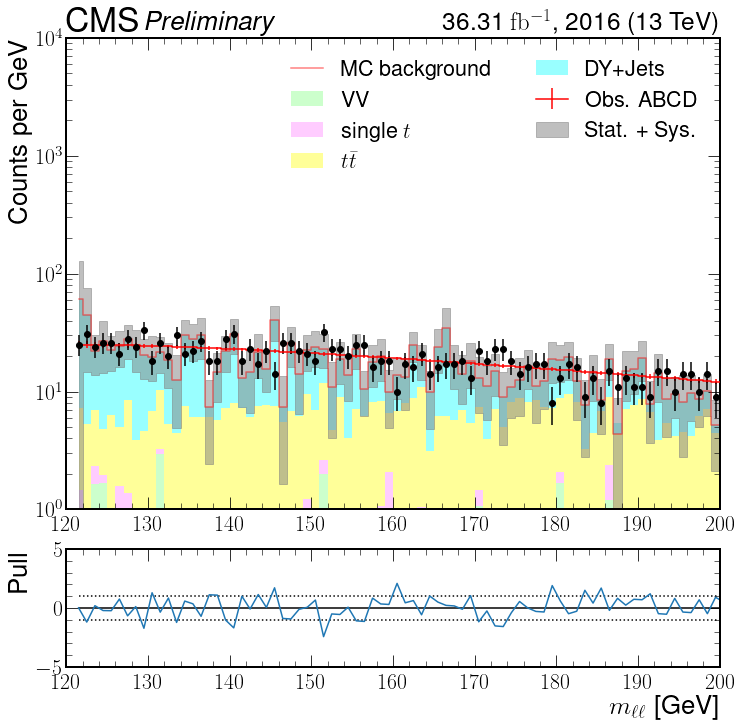

In [60]:
#abcd plots
for nJets in ["","2"]:
    reg = 'CRA{}{}'.format(nJets,postfix)
    #reg = 'CRA{}'.format(nJets)
    #make abcd hist
    abcd_hist = make_abcd(nJets)
    abcd_hist = abcd_hist.rebin(split_bins.bin_edges).reduce_range(bottom=bottom_value, top=top_value).make_density_hist()
    #background hist
    sp.rebin = split_bins.bin_edges
    bhist = sp.combine_back(feature, reg)
    #data hist
    dhist = sp.make_data_hist(feature, reg)
    #reduce the range for fitting
    dhist = dhist.reduce_range(bottom=bottom_value, top=top_value).make_density_hist()
    
    closure_percent = find_68_env(abcd_hist.nominal, dhist.nominal, nJets)

    flabel = 'Obs. ABCD' if isdata else 'MC ABCD'
    ratio_dict = compare_hists(abcd_hist, dhist, isdata=1, n=comp_hist_n, 
                                   color = 'Green', ndof=5, flabel=flabel, ratio=True, isabcd=1, dhist_isdata=isdata)
    
    sp.draw_background(ratio_dict['ax'], feature, reg, sys_label='Stat. + Sys.', errorbar=False)
    
    ratio_dict['rax'].errorbar(dhist.calc_bin_centers(), dhist.nominal/dhist.nominal,
                                yerr=dhist.std/dhist.nominal, color='black', ls='', marker='o', zorder=.5) 
    # color points outside of 68% CL
    draw_outside_closure(ratio_dict['ax'], dhist.calc_bin_centers(), dhist.nominal, abcd_hist.nominal, dhist.std, closure_percent, color='red', zorder=6)
    draw_outside_closure(ratio_dict['rax'], dhist.calc_bin_centers(), dhist.nominal/dhist.nominal, 
                         abcd_hist.nominal/dhist.nominal, dhist.std/dhist.nominal, closure_percent, color='red', zorder=6)

    handles, labels = ratio_dict['ax'].get_legend_handles_labels()
    order = [0,1,2,3,4,6,5]
    if ismc: order = np.linspace(0,len(handles)-1, len(handles), dtype=int)
    ratio_dict['ax'].legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                                ncol=2)
    
    ratio_dict['ax'].set_ylim(bottom=1e0, top=1e4)
    ratio_dict['fig'].savefig('{}/abcd_mc_ratio_era{}_ismc{}_regCR{}{}_bottom{}_lognorm_splt_binning.pdf'.format(outdir,era,ismc,nJets,postfix,bottom_value))
    ##200 GeV zoom in 
    #ratio_dict['ax'].set_xlim(left=bottom_value, right=200)
    #ratio_dict['rax'].set_xlim(left=bottom_value, right=200)
    #ratio_dict['fig'].savefig('{}/abcd_mc_ratio_era{}_ismc{}_regCR{}{}_bottom{}_lognorm_splt_binning_200GeVMax.pdf'.format(outdir,era,ismc,nJets,postfix,bottom_value))

    #ratio
    #pull
    pull_dict = compare_hists(abcd_hist, dhist, isdata=1, n=comp_hist_n, 
                                   color = 'red', ndof=5, flabel=flabel, ratio=False, isabcd=1, dhist_isdata=isdata)
    
    sp.draw_background(pull_dict['ax'], feature, reg, sys_label='Stat. + Sys.', errorbar=False)
    handles, labels = pull_dict['ax'].get_legend_handles_labels()
    order = [0,1,2,3,4,6,5]
    if ismc: order = np.linspace(0,len(handles)-1, len(handles), dtype=int)
    pull_dict['ax'].legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                                ncol=2)
    pull_dict['ax'].set_ylim(bottom=1e0, top=1e4)
    pull_dict['fig'].savefig('{}/abcd_mc_pull_era{}_ismc{}_regCR{}{}_bottom{}_lognorm_splt_binning.pdf'.format(outdir,era,ismc,nJets,postfix,bottom_value))
    #200 GeV zoom in 
    pull_dict['ax'].set_xlim(left=bottom_value, right=200)
    pull_dict['rax'].set_xlim(left=bottom_value, right=200)
    pull_dict['fig'].savefig('{}/abcd_mc_pull_era{}_ismc{}_regCR{}{}_bottom{}_lognorm_splt_binning_200GeVMax.pdf'.format(outdir,era,ismc,nJets,postfix,bottom_value))
    sp.rebin = 0

    #save data
    fit_dict['CRA{}{}_ABCD'.format(nJets, postfix)]= ratio_dict
    fit_dict['CRA{}{}_ABCD'.format(nJets, postfix)]['fit_hist'] = abcd_hist

In [61]:
{reg: item['chi2'] for reg, item in fit_dict.items()}

{'CRA': nan,
 'CRB': nan,
 'CRC': nan,
 'CRD': nan,
 'CRA2': nan,
 'CRB2': nan,
 'CRC2': nan,
 'CRD2': nan,
 'CRA_ABCD': 0.8851942405895189,
 'CRA2_ABCD': 0.6421020443397014}

In [62]:
import inspect

In [63]:
reg

'CRA2'

In [64]:
fit_list = []
for reg, item in fit_dict.items():
    if "ABCD" in reg: continue
    if "CRA" in reg: continue
    if isdata:
        _plot_dict = sp.make_data_hist(feature, reg).reduce_range(bottom=bottom_value, top=top_value)
    else:
        fig, ax = plt.subplots()
        _plot_dict = sp.draw_background(ax, feature, reg).reduce_range(bottom=bottom_value, top=top_value)
    _fit_dict = {
        "era": era,
        "region": reg,
    'n_{background}': "{:.2f}".format(_plot_dict.uncertainty_std_dev().sum()),
    'n_{ABCD,Data}': "{:.2f}".format(item['fit_hist'].uncertainty_std_dev().sum()),
    ' Data $\chi^2/n_{DOF}$': "{:.2f}".format(item['chi2'])
    }
    if not 'SR' in reg:
        popt_unc = uncertainties.correlated_values(item['popt'], item['pcov'])
        param_names = inspect.getfullargspec(log_norm_np).args[1:]
        treg_dict = {**{n:"{:.2f}".format(u) for u, n in zip(popt_unc, param_names) }}
        _fit_dict = {**_fit_dict, **treg_dict}    
    fit_list.append(_fit_dict)

In [65]:
with open('{}/fit_stats_data_{}_ismc{}.txt'.format(outdir,era, ismc), 'w') as f:
    latex = pd.DataFrame(fit_list)[['era', 'region', 'n_{background}',  'n_{ABCD,Data}', 'sigma', 'theta', 'mean',
       ' Data $\chi^2/n_{DOF}$']].to_latex(index=False)
    print(latex)
    f.write(latex)

\begin{tabular}{llllllll}
\toprule
 era & region &    n\_\{background\} &    n\_\{ABCD,Data\} &       sigma &         theta &           mean &  Data \$\textbackslash chi\textasciicircum 2/n\_\{DOF\}\$ \\
\midrule
2016 &    CRB &   2781.00+/-52.74 &   2781.00+/-6.63 & 0.68+/-0.16 & 59.35+/-39.89 &  86.45+/-22.14 &                    nan \\
2016 &    CRC & 18563.00+/-136.25 & 18563.00+/-15.09 & 0.77+/-0.05 & 72.85+/-10.41 &   74.88+/-4.87 &                    nan \\
2016 &    CRD & 27063.00+/-164.51 & 27063.00+/-18.35 & 0.72+/-0.05 & 65.63+/-10.44 &   77.80+/-5.16 &                    nan \\
2016 &   CRB2 &   1629.00+/-40.36 &   1629.00+/-5.25 & 0.70+/-0.23 & 56.79+/-58.45 & 100.00+/-33.22 &                    nan \\
2016 &   CRC2 &   4157.00+/-64.47 &   4157.00+/-7.65 & 0.85+/-0.21 & 50.00+/-80.21 &  71.24+/-10.79 &                    nan \\
2016 &   CRD2 &   6096.00+/-78.08 &   6096.00+/-7.76 & 0.81+/-0.13 & 50.00+/-48.01 &  74.01+/-10.33 &                    nan \\
\bottomrule
\end{ta

In [66]:
tdf = pd.DataFrame(fit_list)[['era', 'region', 'n_{background}',  'sigma', 'theta', 'mean', 'n_{ABCD,Data}',
       ' Data $\chi^2/n_{DOF}$']]
tdf
tdf = pd.DataFrame(fit_list)[['era', 'region', 'n_{background}',  'sigma', 'theta', 'mean', 'n_{ABCD,Data}']]
tdf

,era,region,n_{background},sigma,theta,mean,"n_{ABCD,Data}"
0,2016,CRB,2781.00+/-52.74,0.68+/-0.16,59.35+/-39.89,86.45+/-22.14,2781.00+/-6.63
1,2016,CRC,18563.00+/-136.25,0.77+/-0.05,72.85+/-10.41,74.88+/-4.87,18563.00+/-15.09
2,2016,CRD,27063.00+/-164.51,0.72+/-0.05,65.63+/-10.44,77.80+/-5.16,27063.00+/-18.35
3,2016,CRB2,1629.00+/-40.36,0.70+/-0.23,56.79+/-58.45,100.00+/-33.22,1629.00+/-5.25
4,2016,CRC2,4157.00+/-64.47,0.85+/-0.21,50.00+/-80.21,71.24+/-10.79,4157.00+/-7.65
5,2016,CRD2,6096.00+/-78.08,0.81+/-0.13,50.00+/-48.01,74.01+/-10.33,6096.00+/-7.76


In [67]:
40665*5778.39/28601

8215.734741792246

In [68]:
#format dict for saving
limit_dict = {}
for reg, item in fit_dict.items():
    limit_dict[reg] = item['fit_hist'].to_dict()

In [69]:
import pickle as pkl
with open('{}/abcd_dict_data_{}_ismc{}.pkl'.format(outdir, era, ismc), 'wb') as f:
    pkl.dump(limit_dict, f)

In [70]:
fit_dict_skimmed = {}
for k, v in fit_dict.items():
    v = {k2:v2 for k2,v2 in v.items() if not k2 in ['fig', 'ax','rax']}
    fit_dict_skimmed[k] = v

In [71]:
import pickle as pkl
with open('{}/fit_dict_data_{}_ismc{}.pkl'.format(outdir, era, ismc), 'wb') as f:
    pkl.dump(fit_dict_skimmed, f)

In [72]:
'{}/abcd_dict_data_{}_ismc{}.pkl'.format(outdir, era, ismc)

'/eos/cms/store/group/phys_exotica/bffZprime/assets_june_23/abcd_test/abcd_dict_data_2016_ismc0.pkl'

In [73]:
from src.assets.regions import regions
from uncertainties import ufloat

In [74]:
for reg in regions:
    sp.combine_back(feature, reg)

In [75]:
#region composition
reg_list = []
for reg in test_regions:
    bdf = sp.bck_df(feature, reg)
    print(reg)
    reg_dict = {'reg': reg}
    
    total = 0
    category = "" 
    cat_sum = 0
    for i, row in bdf.iterrows():
        if row.category not in reg_dict:
            reg_dict[row.category] = 0
        reg_sum = row.nom.sum()
        reg_std = row.nom.std()
        print(row.category, reg_sum, reg_std)
        reg_dict[row.category] += reg_sum
        total+=row.nom.sum()
    reg_list.append(reg_dict)
    print("----")
    for i, row in bdf.iterrows():
        print(row.category, row.nom.sum()/total) 
    print("---\n")

CRA
ST 92.04338294968875 0.24155498869653574
ST 99.83614856938941 0.25492024955492626
VB 7.159816720139097 0.06302439966851243
VB 18.92009004999125 0.2163106153341131
VB 12.16223333656711 0.10241476695910628
TT 1001.0325561773798 2.0668197210694426
DY 3711.9391933223683 11.353666108923287
----
ST 0.01862060355896143
ST 0.02019709927850344
VB 0.0014484485948697353
VB 0.0038275809170693798
VB 0.0024604498237052975
TT 0.20251135693677594
DY 0.7509344608901148
---

CRB
ST 70.82323157437983 0.2100400206683623
ST 70.43768132270493 0.19376015397969545
VB 5.799273969130397 0.058525266176167844
VB 12.99370776344212 0.16469647877446628
VB 10.810942077240892 0.09631746358137674
TT 697.75237714982 1.5402386457605217
DY 2511.9497282723773 7.455407280210782
----
ST 0.020950104756622585
ST 0.02083605576475968
VB 0.0017154737854349334
VB 0.003843647525955699
VB 0.003197967164179898
TT 0.20640099400320483
DY 0.7430557569998424
---

CRC
ST 117.96059332322348 0.3011682531689876
ST 124.75563915989179 0.30

In [76]:
df = pd.DataFrame(reg_list)

In [77]:
sum_axis1 = df[['DY', 'TT', 'ST', 'VB']].sum(axis=1)

In [78]:
prop_df = df[['DY', 'TT', 'ST', 'VB']].div(sum_axis1, axis=0)

In [79]:
prop_df['reg'] = df.reg

In [80]:
df

,reg,ST,VB,TT,DY
0,CRA,191.879532,38.242140,1001.032556,3711.939193
1,CRB,141.260913,29.603924,697.752377,2511.949728
2,CRC,242.716232,164.045105,1142.546474,20643.457819
3,CRD,334.601920,254.106401,1654.311377,29584.761980
4,CRA2,87.885238,41.695801,968.517534,1671.130738
5,CRB2,67.204913,21.089473,672.321627,1127.932871
6,CRC2,62.630072,75.878474,490.082159,4455.646043
7,CRD2,94.966062,105.993799,762.968564,6310.109561


In [81]:
for i, row in prop_df [['reg', 'DY', 'TT', 'ST', 'VB']].iterrows():
    print("{reg} & {DY:.2f} &  {TT:.2f} & {ST:.2f} & {VB:.2f} \\\\".format(**row.to_dict()))

CRA & 0.75 &  0.20 & 0.04 & 0.01 \\
CRB & 0.74 &  0.21 & 0.04 & 0.01 \\
CRC & 0.93 &  0.05 & 0.01 & 0.01 \\
CRD & 0.93 &  0.05 & 0.01 & 0.01 \\
CRA2 & 0.60 &  0.35 & 0.03 & 0.02 \\
CRB2 & 0.60 &  0.36 & 0.04 & 0.01 \\
CRC2 & 0.88 &  0.10 & 0.01 & 0.01 \\
CRD2 & 0.87 &  0.10 & 0.01 & 0.01 \\


In [82]:
prop_df

,DY,TT,ST,VB,reg
0,0.750934,0.202511,0.038818,0.007736,CRA
1,0.743056,0.206401,0.041786,0.008757,CRB
2,0.930189,0.051483,0.010937,0.007392,CRC
3,0.929526,0.051977,0.010513,0.007984,CRD
4,0.603464,0.349743,0.031736,0.015057,CRA2
5,0.597248,0.355999,0.035585,0.011167,CRB2
6,0.876365,0.096392,0.012318,0.014924,CRC2
7,0.867484,0.104889,0.013055,0.014572,CRD2


In [83]:
# signal contam test
dir(sp)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'bck_df',
 'combine_back',
 'combine_hists',
 'draw_background',
 'draw_data',
 'draw_signals',
 'draw_signals_compare_dbs',
 'era',
 'feature_reg_df',
 'get_signal_hist',
 'make_data_hist',
 'make_hist',
 'plot_df',
 'rebin',
 'scale',
 'select_hists',
 'stich_dy',
 'x_range']

In [84]:
##
## Sig contam test
##

In [85]:
limit_df = pd.read_csv('{}/combine_data/{}_count_limits.csv'.format(output_dir, era))


In [86]:
signal_strength = limit_df[(limit_df.mass==200)&(limit_df.nJets=='SR1')&(limit_df.dbs==0.04)].iloc[0]['50.0']
feature, reg = 'DiLepMass', 'SR1'
reg2 = 'CRA'

SR_sum = sp.get_signal_hist(feature, reg, mass=200, dbs=0.04).iloc[0].nom.sum()*signal_strength
SR_backsum = sp.combine_back(feature, reg).calc_sum()
LSR_sum = sp.get_signal_hist(feature, reg2, mass=200, dbs=0.04).iloc[0].nom.sum()*signal_strength
LSR_backsum = sp.combine_back(feature, reg2).calc_sum()

In [87]:
SR_sum, LSR_sum

(57.73331597209598, 8.673793630591845)

In [88]:
SR_backsum, LSR_backsum

(5177.65536370842, 3824.962133349362)

In [89]:
signal_strength = limit_df[(limit_df.mass==200)&(limit_df.nJets=='SR2')&(limit_df.dbs==0.04)].iloc[0]['50.0']
feature, reg = 'DiLepMass', 'SR2'
reg2 = 'CRA2'

SR_sum = sp.get_signal_hist(feature, reg, mass=200, dbs=0.04).iloc[0].nom.sum()*signal_strength
SR_backsum = sp.combine_back(feature, reg).calc_sum()
LSR_sum = sp.get_signal_hist(feature, reg2, mass=200, dbs=0.04).iloc[0].nom.sum()*signal_strength
LSR_backsum = sp.combine_back(feature, reg2).calc_sum()

In [90]:
SR_sum, LSR_sum

(42.940722639274185, 5.916503138787135)

In [91]:
SR_backsum, LSR_backsum

(3780.518844756159, 2211.059589143755)

In [93]:
#ratio plot with ABCD test
def make_uncertainty_dict(reg):
    nom, std = abcd[reg]['nom'], abcd[reg]['std']
    max_val, min_val, summed = np.max(std/nom), np.min(std/nom), np.sum(std)/np.sum(nom)
    avg = np.average(std/nom)
    return {"era": era, "reg": reg, 
            "max_val": max_val, "min_val": min_val, "summed": summed, "avg":avg}


import pickle as pkl
firstHist=1
reg_dict = {}
uncertainty_list = []
for _era in ["2016"]:
    #if _era !="2016": continue
    outname="{}/abcd/abcd_dict_data_{}_ismc0.pkl".format(output_dir, _era)
    with open(outname,'rb') as f:
        abcd = pkl.load(f)
        for reg in abcd.keys():
            if'SR' in reg: uncertainty_list.append(make_uncertainty_dict(reg))
            
            if firstHist==1:
                reg_dict[reg] = SysHist.from_dict(abcd[reg])
            else:
                reg_dict[reg] += SysHist.from_dict(abcd[reg])
        firstHist=0
uncertainty_df = pd.DataFrame(uncertainty_list)



/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


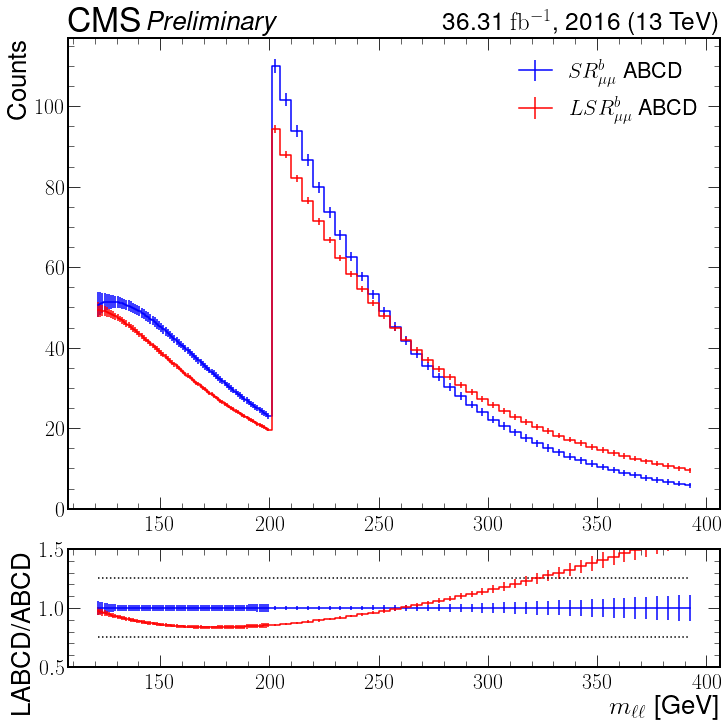

In [121]:
fig, ax, rax = ratio_plot_template(figsize=(10,10))

reg_dict['SR1'].draw(ax, label='$SR_{\mu\mu}^{b}$ ABCD')
fit_dict['CRA']['fit_hist'].reduce_range(120,400).draw(ax, color='red', label='$LSR_{\mu\mu}^{b}$ ABCD')
ax.legend()
cms_format_fig(era, ax, '\emph{Preliminary}')
reg_dict['SR1'].calc_ratio(reg_dict['SR1'].nominal).draw(rax ,  label='$SR_{\mu\mu}^{b}$ ABCD')
fit_dict['CRA']['fit_hist'].reduce_range(120,400).calc_ratio(reg_dict['SR1'].nominal).draw(rax , color='red', label='$LSR_{\mu\mu}^{b}$ ABCD')
rax.set_ylim(0.5,1.5)

x= reg_dict['SR1'].calc_bin_centers()
rax.plot(x, np.full(len(x), .75) , color='black', linestyle=':')
rax.plot(x, np.full(len(x), 0) , color='black')
rax.plot(x, np.full(len(x), 1.25) , color='black', linestyle=':') 

ax.set_ylabel('Counts')

rax.set_ylabel('LABCD/ABCD')
rax.set_xlabel('$m_{\\ell\\ell}$ [GeV]')
fig.savefig('{}/SR_v_LSR_{}_{}.pdf'.format(outdir,era,postfix))